# Import Data

In [1]:
import os

!git clone https://github.com/jihoo-kim/Coronavirus-Dataset
PATIENT_PATH = "/content/Coronavirus-Dataset/patient.csv"

Cloning into 'Coronavirus-Dataset'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 456 (delta 22), reused 0 (delta 0), pack-reused 410
Receiving objects: 100% (456/456), 246.06 KiB | 2.03 MiB/s, done.
Resolving deltas: 100% (276/276), done.


In [2]:
import os

!git clone https://github.com/ClementBM/Experiment_Coronavius.git
PYRAMID_PATH = "/content/Experiment_Coronavius/data/population-pyramid-south-korea.csv"

Cloning into 'Experiment_Coronavius'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 37 (delta 12), reused 25 (delta 4), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [0]:
import pandas as pd

df_korea_patients = pd.read_csv(PATIENT_PATH)
df_korea_population_pyramid = pd.read_csv(PYRAMID_PATH)

# EDA Patients

In [4]:
df_korea_patients.head()
display(df_korea_patients.head())
display(df_korea_patients.shape)
display(df_korea_patients.columns)
display(df_korea_patients.iloc[:10,:10].dtypes)

,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
0,1,female,1984.0,China,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
1,2,male,1964.0,Korea,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
2,3,male,1966.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
3,4,male,1964.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
4,5,male,1987.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released


(7754, 15)

Index(['patient_id', 'sex', 'birth_year', 'country', 'region', 'disease',
       'group', 'infection_reason', 'infection_order', 'infected_by',
       'contact_number', 'confirmed_date', 'released_date', 'deceased_date',
       'state'],
      dtype='object')

patient_id            int64
sex                  object
birth_year          float64
country              object
region               object
disease             float64
group                object
infection_reason     object
infection_order     float64
infected_by          object
dtype: object

## Cleaning data

In [0]:
# drop sample if sex or birth_year is NaN
not_nan = df_korea_patients['birth_year'].notna() & df_korea_patients['sex'].notna()
df_korea_patients = df_korea_patients[not_nan]
# typo
df_korea_patients["sex"] = df_korea_patients["sex"].replace("feamle", "female")

df_korea_patients['age'] = 2020 - df_korea_patients['birth_year'] 

In [6]:
df_korea_patients.head()
display(df_korea_patients.head())
display(df_korea_patients.shape)
display(df_korea_patients.columns)
display(df_korea_patients.iloc[:10,:10].dtypes)

,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state,age
0,1,female,1984.0,China,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released,36.0
1,2,male,1964.0,Korea,filtered at airport,NaN,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released,56.0
2,3,male,1966.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released,54.0
3,4,male,1964.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released,56.0
4,5,male,1987.0,Korea,capital area,NaN,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released,33.0


(710, 16)

Index(['patient_id', 'sex', 'birth_year', 'country', 'region', 'disease',
       'group', 'infection_reason', 'infection_order', 'infected_by',
       'contact_number', 'confirmed_date', 'released_date', 'deceased_date',
       'state', 'age'],
      dtype='object')

patient_id            int64
sex                  object
birth_year          float64
country              object
region               object
disease             float64
group                object
infection_reason     object
infection_order     float64
infected_by          object
dtype: object

## Distribution

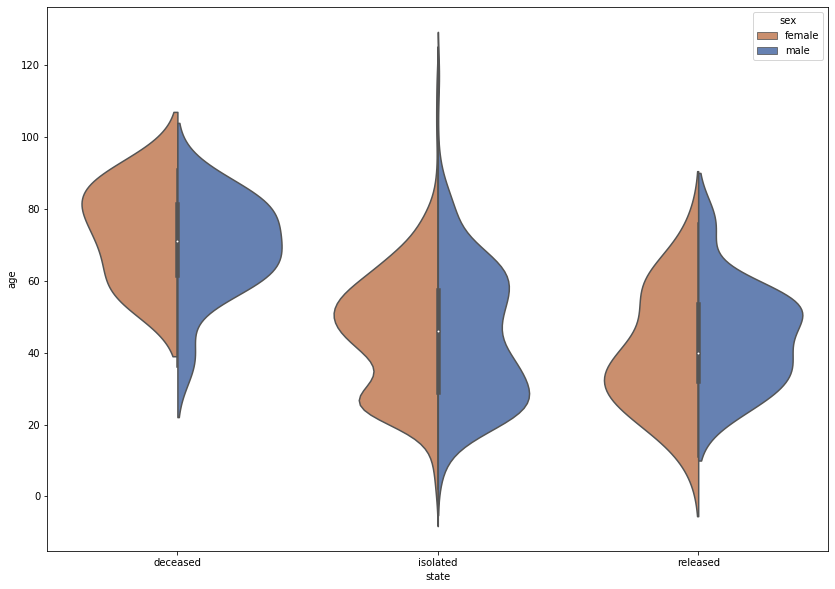

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,10))
sns.violinplot(x="state", y="age", hue="sex", data=df_korea_patients,
               order=["deceased", "isolated", "released"], 
               palette={"female": "#d98b5f", 
                        "male": "#597dbf"}, 
               split=True)
plt.show()

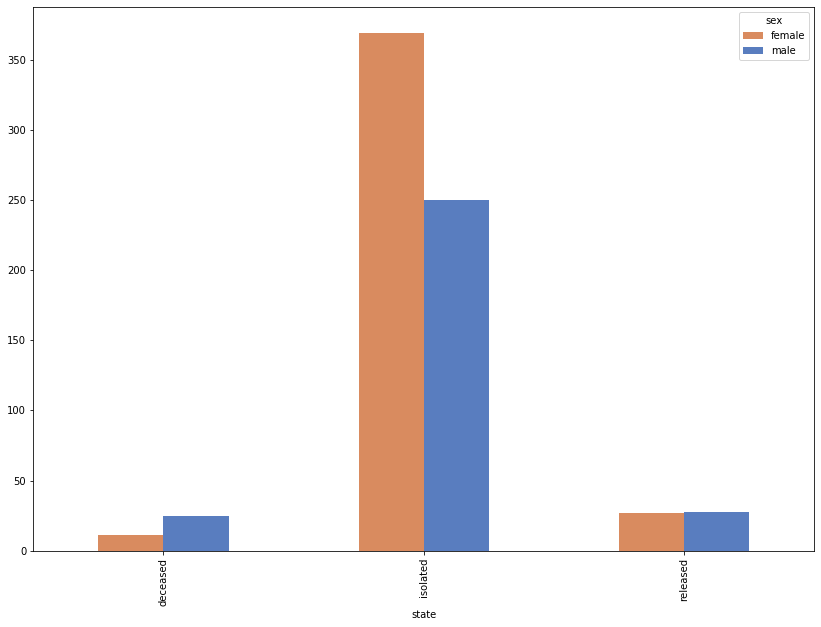

In [8]:
df_korea_patients_by_age_sex = df_korea_patients.groupby(["state", "sex"], 
                                                         as_index=False)["state", "sex"].size()

df_korea_patients_by_age_sex.unstack().plot(kind='bar', 
                                            color=['#d98b5f', '#597dbf'],
                                            figsize=(14, 10))

plt.show()

## Age pyramid

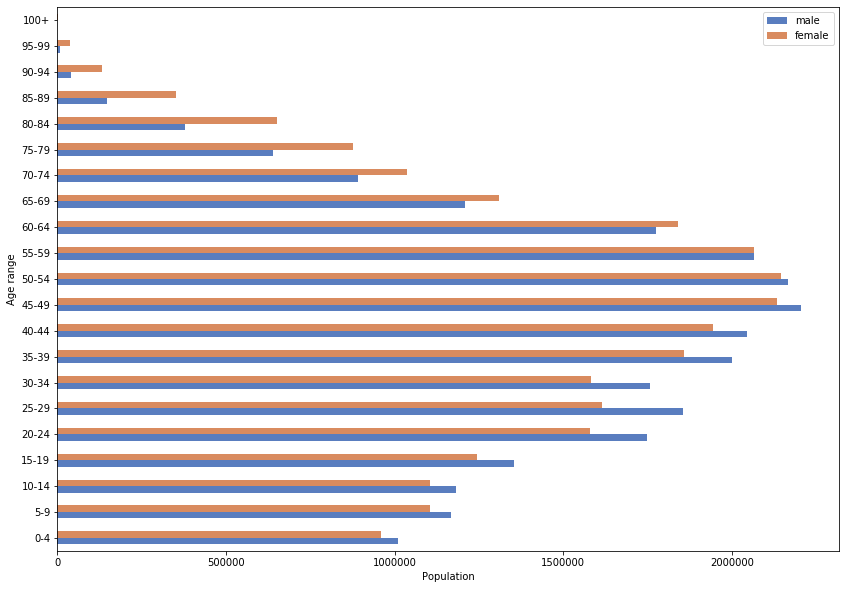

In [9]:
df_korea_population_pyramid.plot(kind='barh',
                                 x="age_range",
                                 color=['#597dbf', '#d98b5f'],
                                 figsize=(14, 10))
plt.xlabel("Population")
plt.ylabel("Age range")
plt.legend()
plt.show()

### Adding age range 

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt

def group_age(age, window):
  if age > 99:
    return "100+"
  if age % 5 != 0:
      lower = int(math.floor(age / float(window))) * window
      upper = int(math.ceil(age / float(window))) * window - 1
      return f"{lower}-{upper}"
  else:
      lower = int(age)
      upper = int(age + window - 1) 
      return f"{lower}-{upper}"

def group_age_by_5(age):
  return group_age(age, 5)

In [0]:
df_korea_patients["age_range"] = df_korea_patients["age"].apply(group_age_by_5)

### Age range dictionary for ordering values

In [0]:
age_range_order = df_korea_population_pyramid["age_range"].to_dict()
age_range_order = {v: k for k, v in age_range_order.items()}

### Age pyramid proportion

In [0]:
total_male = sum(df_korea_population_pyramid.loc[:,'male'])
total_female = sum(df_korea_population_pyramid.loc[:,'female'])

df_korea_population_pyramid["male_prop"] = df_korea_population_pyramid["male"] / total_male
df_korea_population_pyramid["female_prop"] = df_korea_population_pyramid["female"] / total_female

In [0]:
def infected_population_normed(df):
  result = df.groupby(["age_range", "sex"], as_index=False)["age_range", "sex"].size()
  
  result = (
    pd.DataFrame(result)
    .pivot_table(index=["age_range"], columns=["sex"], fill_value=0.0)
    .reset_index()
  )

  result = result.set_index("age_range")
  
  result = result[0] # unstack() ?
  result["order"] = [age_range_order[x] for x in result.index]
  result = result.sort_values(by="order")
  
  indices = [age_range_order[x] for x in result.index]
  df_normed = pd.DataFrame(index=df_korea_population_pyramid["age_range"], columns=["male","female"])

  df_normed.loc[result.index, "male"] = result["male"] / df_korea_population_pyramid.loc[indices]["male_prop"].values
  df_normed.loc[result.index, "female"] = result["female"] / df_korea_population_pyramid.loc[indices]["female_prop"].values

  df_normed = df_normed.replace(np.inf, 0)
  df_normed = df_normed.replace(np.nan, 0)

  df_normed["male"] = df_normed["male"] * 100 / sum(df_normed["male"])
  df_normed["female"] = df_normed["female"] * 100 / sum(df_normed["female"])

  distribution_normed = pd.DataFrame({'male': df_normed["male"], 'female': df_normed["female"]})
  distribution_normed = distribution_normed.reset_index()

  return distribution_normed

In [0]:
def plot_normed_distribution(df):
  distribution_normed = infected_population_normed(df)

  df = pd.DataFrame({'male': distribution_normed['male'].values, 'female': distribution_normed['female'].values}, index=distribution_normed["age_range"])
  df.plot.barh(figsize=(14, 10), color=['#597dbf', '#d98b5f'])

  plt.xlabel("Proportion %")
  plt.ylabel("Age range")
  plt.legend()
  plt.show()

## Normed distribution of all

710

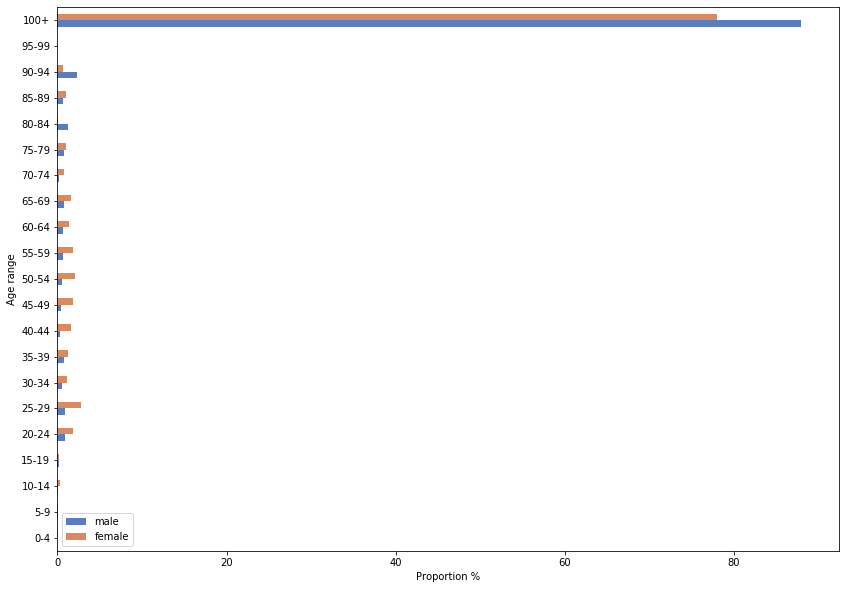

In [16]:
display(df_korea_patients.shape[0])
plot_normed_distribution(df_korea_patients)

In [17]:
display(df_korea_patients[df_korea_patients["age_range"] == "100+"])
display(df_korea_population_pyramid[df_korea_population_pyramid["age_range"] == "100+"])

,patient_id,sex,birth_year,country,region,disease,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state,age,age_range
5659,5661,female,1905.0,Korea,capital area,NaN,NaN,contact with patient,NaN,NaN,NaN,2020-03-04,NaN,NaN,isolated,115.0,100+
6068,6070,male,1903.0,Korea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-04,NaN,NaN,isolated,117.0,100+
6843,6845,female,1913.0,Korea,capital area,NaN,NaN,contact with patient,NaN,NaN,NaN,2020-03-07,NaN,NaN,isolated,107.0,100+
7217,7219,female,1920.0,Korea,capital area,NaN,NaN,contact with patient,7103.0,NaN,NaN,2020-03-08,NaN,NaN,isolated,100.0,100+


,age_range,male,female,male_prop,female_prop
20,100+,517,3350,0.00002,0.000131


710

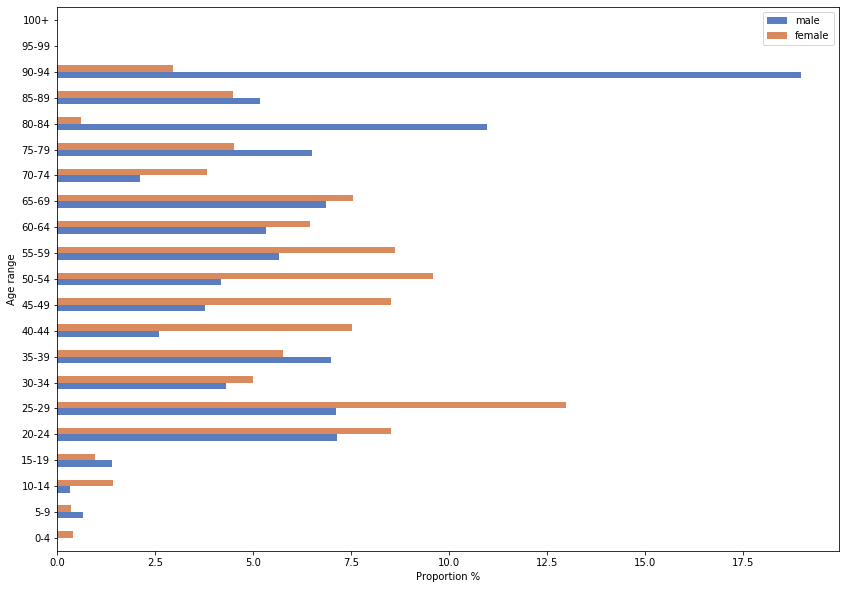

In [18]:
display(df_korea_patients.shape[0])
plot_normed_distribution(df_korea_patients[df_korea_patients["age_range"] != "100+"])

## Normed proportion of **deceased**

36

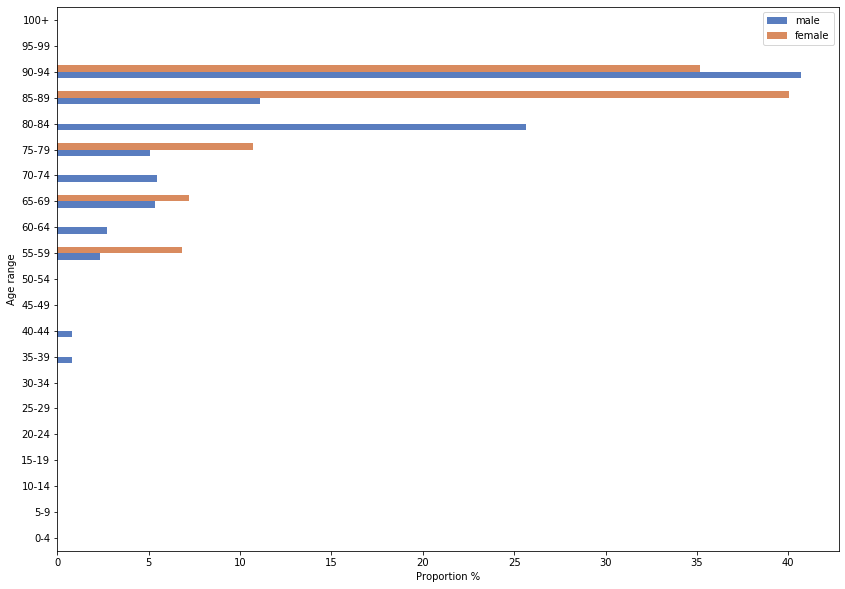

In [19]:
df_deceased = df_korea_patients[df_korea_patients["state"] == "deceased"]
display(df_deceased.shape[0])
plot_normed_distribution(df_deceased)

## Normed proportion of **released**

55

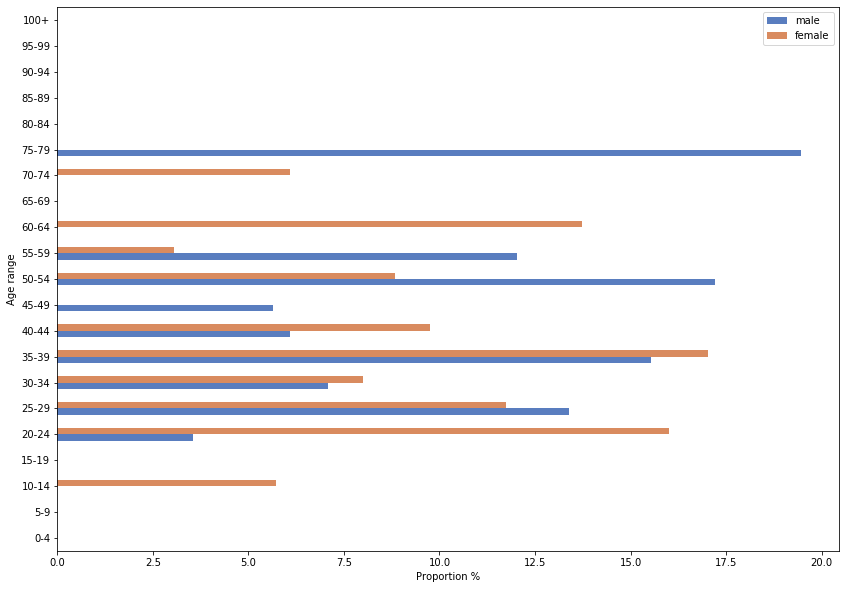

In [20]:
df_released = df_korea_patients[df_korea_patients["state"] == "released"]
display(df_released.shape[0])
plot_normed_distribution(df_released)

## Normed proportion of **isolated**

615

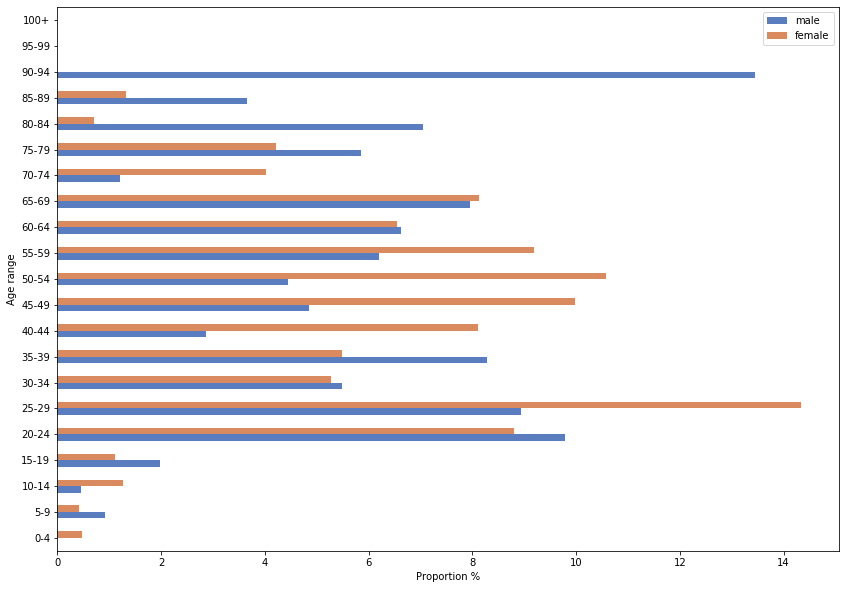

In [21]:
df_released = df_korea_patients[(df_korea_patients["state"] == "isolated") & (df_korea_patients["age_range"] != "100+")]
display(df_released.shape[0])
plot_normed_distribution(df_released)